## Setup environment

In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 7.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 9.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 8.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.4 MB/s eta 0:00:00


In [ ]:
!pip install torch --upgrade
!pip install transformers --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 2.3 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.2.0
    Uninstalling triton-2.2.0:
      Successfully uninstalled triton-2.2.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.19.3
    Uninstalling nvidia-nccl-cu12-2.19.3:
      Successfully uninstalled nvidia-nccl-cu12-2.19.3
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1+cu121
    Uninstalling torch-2.2.1+cu121:
      Successfully uninstalled torch-2.2.1+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.1+cu121 requires torch==2.2.1, but you have torch 2

In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=1bf9e8de47c45db8d20a152b0ace36d11f2ea494247dfad65acd178cf8de0e14
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


## Import libs

In [ ]:
from datasets import load_dataset, load_metric
from torch.utils.data import Dataset, DataLoader
from transformers import AutoProcessor, Blip2ForConditionalGeneration, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from matplotlib import pyplot as plt
from tqdm import tqdm
from PIL import Image
import torch
import io
import requests

## Load dataset and pretrained model

In [ ]:
# Load dataset from huggingface
dataset = load_dataset("chocopiee/vnfoods", split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/83 [00:00<?, ? examples/s]

In [ ]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = item["text"]
        return encoding

def collate_fn(batch):
    # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch

In [ ]:
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
quantization_config = BitsAndBytesConfig(
    load_in_8bit=True,  # Enable 8-bit quantization
    llm_int8_threshold=6.0  # Optional: set a threshold for which layers to quantize (default is 6.0)
)

model = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded", device_map="auto", quantization_config=quantization_config)

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/7.05k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

pytorch_model-00001-of-00008.bin:   0%|          | 0.00/995M [00:00<?, ?B/s]

pytorch_model-00002-of-00008.bin:   0%|          | 0.00/999M [00:00<?, ?B/s]

pytorch_model-00003-of-00008.bin:   0%|          | 0.00/985M [00:00<?, ?B/s]

pytorch_model-00004-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00005-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00006-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00007-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00008-of-00008.bin:   0%|          | 0.00/782M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
# Let's define the LoraConfig
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 5,242,880 || all params: 3,749,922,816 || trainable%: 0.1398


In [ ]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=3, collate_fn=collate_fn)

## Continue train model with custom dataset

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.train()

for epoch in range(100):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device, torch.float16)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0
Loss: 3.791015625
Loss: 3.208984375
Loss: 4.34375
Loss: 3.7890625
Loss: 3.01953125
Loss: 2.771484375
Loss: 3.04296875
Loss: 2.421875
Loss: 2.8046875
Loss: 2.783203125
Loss: 2.361328125
Loss: 2.748046875
Loss: 2.841796875
Loss: 1.99609375
Loss: 2.62890625
Loss: 2.337890625
Loss: 1.8916015625
Loss: 2.1953125
Loss: 2.115234375
Loss: 2.193359375
Loss: 2.056640625
Loss: 1.94140625
Loss: 2.0078125
Loss: 1.5615234375
Loss: 1.7470703125
Loss: 1.7900390625
Loss: 2.3515625
Loss: 1.865234375
Epoch: 1
Loss: 1.697265625
Loss: 1.8046875
Loss: 1.5556640625
Loss: 1.541015625
Loss: 1.736328125
Loss: 1.4970703125
Loss: 1.6298828125
Loss: 1.32421875
Loss: 1.361328125
Loss: 1.4931640625
Loss: 1.6845703125
Loss: 1.388671875
Loss: 1.740234375
Loss: 1.1669921875
Loss: 1.3076171875
Loss: 1.287109375
Loss: 1.1923828125
Loss: 1.8505859375
Loss: 1.2548828125
Loss: 1.4990234375
Loss: 1.1142578125
Loss: 1.5595703125
Loss: 1.291015625
Loss: 1.2705078125
Loss: 1.3408203125
Loss: 1.3076171875
Loss: 0.7929687

## Predict

Text(0.5, 1.0, 'Generated caption: A bowl of bún bò Huế, a Vietnamese noodle soup, featuring rice vermicelli noodles, slices of beef, pork knuckle, and a rich, flavorful broth garnished with fresh herbs and')

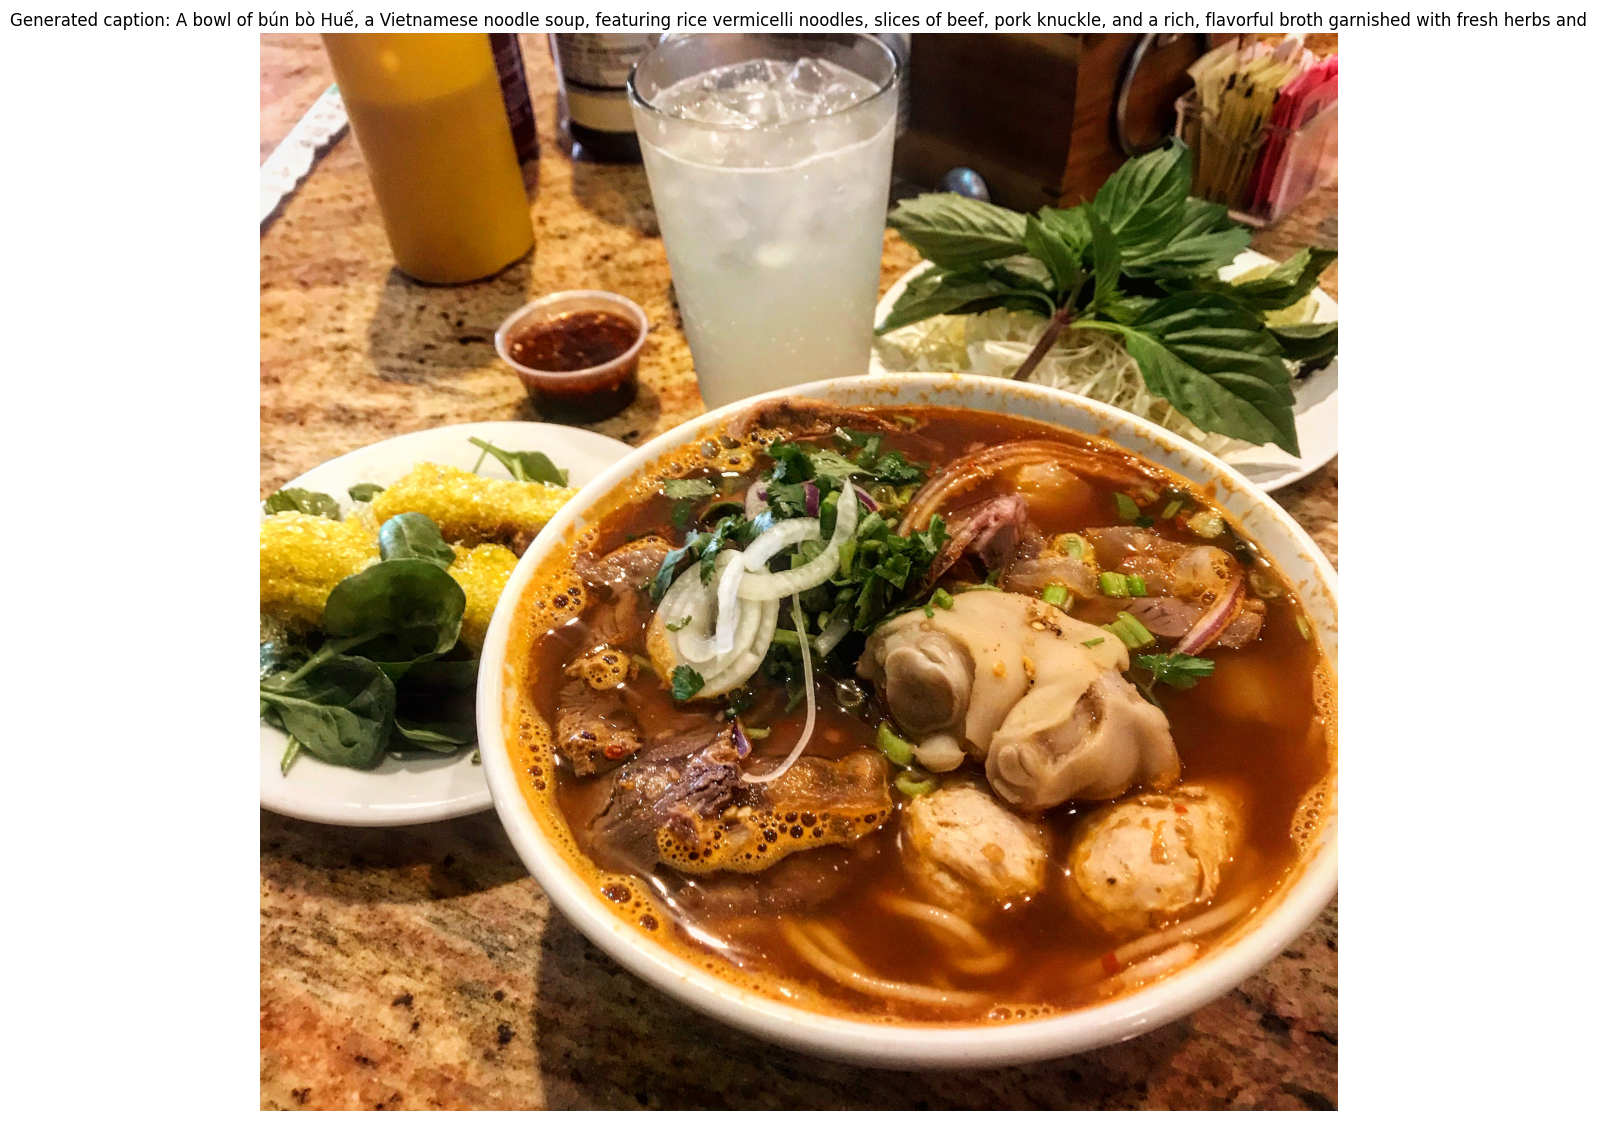

In [ ]:
# load image
image_path = '/content/bunbohue_2.jpg'
image = Image.open(image_path)

fig = plt.figure(figsize=(18, 14))
inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=100)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

plt.imshow(image)
plt.axis("off")
plt.title(f"Generated caption: {generated_caption}")

Text(0.5, 1.0, 'Generated caption: A steaming bowl of bún bò Huế, a popular Vietnamese noodle soup, featuring tender slices of beef, pork knuckle, and a flavorful broth garnished with fresh herbs and chili peppers.')

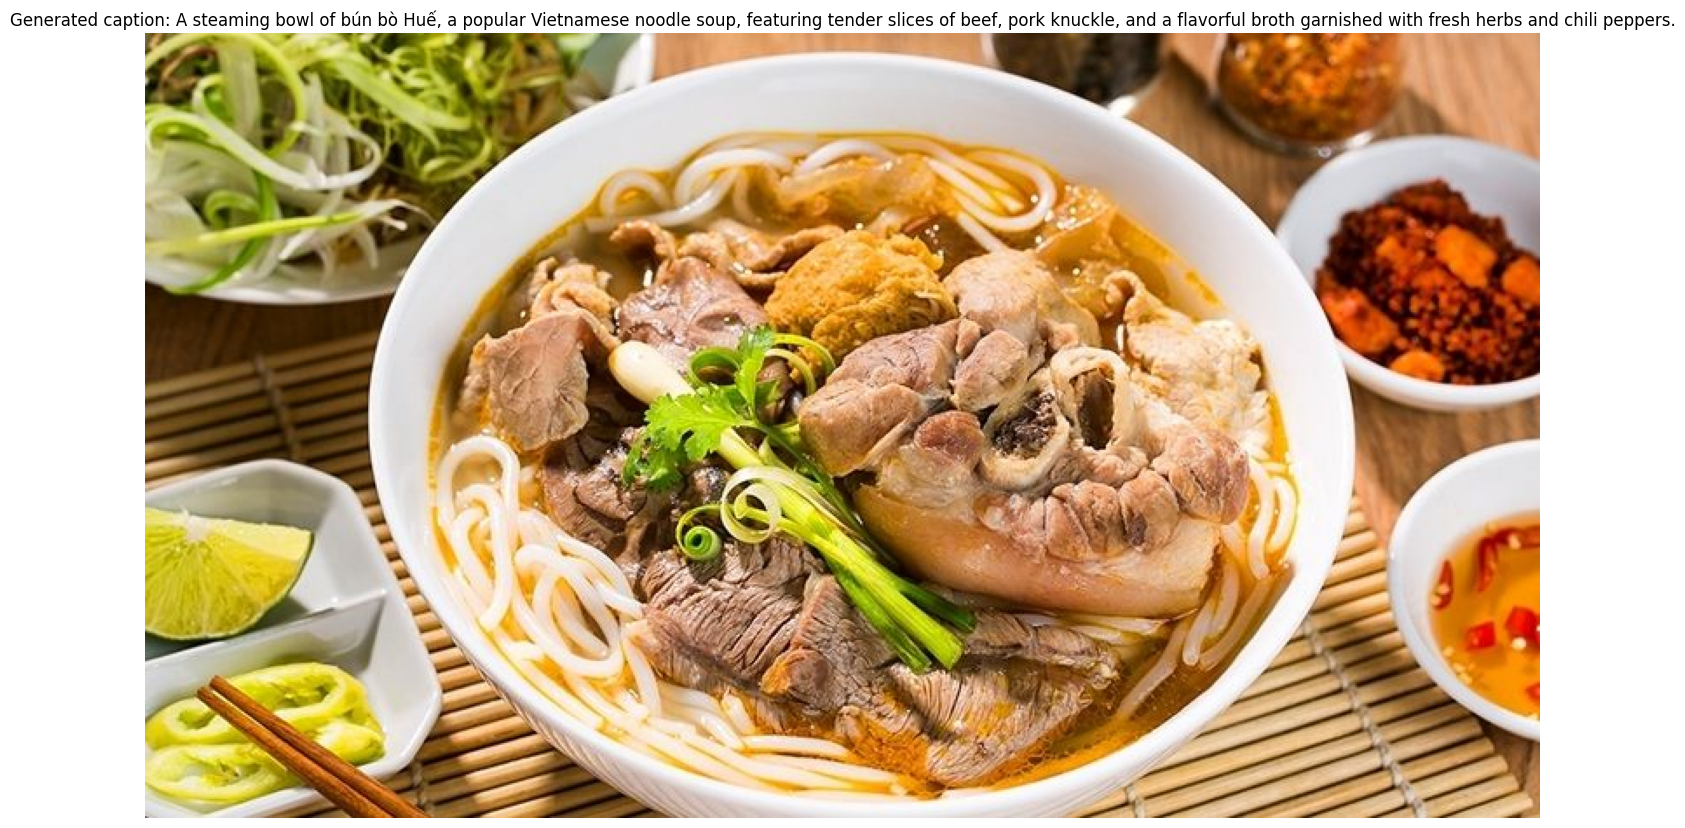

In [ ]:
# other images
url = 'https://cdn.tgdd.vn/Files/2018/04/01/1078873/nau-bun-bo-hue-cuc-de-tai-nha-tu-vien-gia-vi-co-san-202109161718317187.jpg'
response = requests.get(url, stream=True)
image = Image.open(response.raw).convert('RGB')

fig = plt.figure(figsize=(18, 14))
inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=100)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

plt.imshow(image)
plt.axis("off")
plt.title(f"Generated caption: {generated_caption}")

## Evaluate

In [ ]:
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in train_dataloader:
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device, torch.float16)

        outputs = model.generate(pixel_values=pixel_values, max_length=50)
        preds = processor.batch_decode(outputs, skip_special_tokens=True)
        labels = processor.batch_decode(input_ids, skip_special_tokens=True)

        all_preds.extend(preds)
        all_labels.extend(labels)

# Compute metrics
bleu = load_metric("bleu")
rouge = load_metric("rouge")

bleu_score = bleu.compute(predictions=[pred.split() for pred in all_preds], references=[[label.split()] for label in all_labels])
rouge_score = rouge.compute(predictions=all_preds, references=all_labels)

print("BLEU Score:", bleu_score)
print("ROUGE Score:", rouge_score)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for bleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/bleu/bleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major r

BLEU Score: {'bleu': 0.7939087381333401, 'precisions': [0.9897959183673469, 0.9869816779170685, 0.9839357429718876, 0.981151832460733], 'brevity_penalty': 0.8056216997102909, 'length_ratio': 0.8222730739893211, 'translation_length': 2156, 'reference_length': 2622}
ROUGE Score: {'rouge1': AggregateScore(low=Score(precision=0.9585405131980893, recall=0.8156379593132727, fmeasure=0.8750775769275417), mid=Score(precision=0.9851342003960541, recall=0.8562522265338719, fmeasure=0.9083814871729268), high=Score(precision=0.9987951807228914, recall=0.8926353706267712, fmeasure=0.9341748677125224)), 'rouge2': AggregateScore(low=Score(precision=0.9560036538103066, recall=0.813040332410118, fmeasure=0.8709764411351116), mid=Score(precision=0.983561491784601, recall=0.8511125951044995, fmeasure=0.9041879410114047), high=Score(precision=0.9974265885380604, recall=0.8883274748095669, fmeasure=0.9298012022440125)), 'rougeL': AggregateScore(low=Score(precision=0.9573604855856062, recall=0.8123958339208